In [2]:
import requests
import zipfile
from io import BytesIO

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

import statsmodels.api as sm

from pickle import dump
from pickle import load

import warnings
warnings.filterwarnings('ignore')

In [3]:
url = "https://www.federalreserve.gov/econres/files/rscfp2009panelexcel.zip"
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    xlsx_files = [f for f in zip_ref.namelist() if f.endswith('.xlsx')]
    if 'SCFP2009panel.xlsx' in xlsx_files:
        with zip_ref.open('SCFP2009panel.xlsx') as xlsx_file:
            dataset = pd.read_excel(xlsx_file)
            print(dataset.shape)

(19285, 515)


In [4]:
# Media del SP500 entre 2007 y 2009
Average_SP500_2007 = 1478
Average_SP500_2009 = 948

# Tolerancia al riesgo en 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07'] / (dataset['Risky07'] + dataset['RiskFree07'])

# Tolerancia al riesgo en 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = (dataset['Risky09'] / (dataset['Risky09'] + dataset['RiskFree09']) * 
                   Average_SP500_2009 / Average_SP500_2007)

In [5]:
# Hacer la primera copia del dataset
dataset2 = copy.deepcopy(dataset)
# Calcular el porcentaje de la diferencia de la tolerancia al riesgo entre 2007 y 2009
dataset2['PercentageChange'] = np.abs(dataset2['RT09'] / dataset2['RT07'] - 1)
# Eliminar filas con valores nulos
dataset2 = dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

<Axes: xlabel='RT07'>

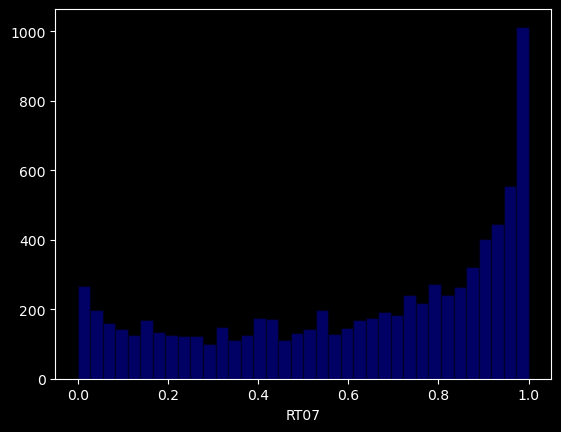

In [6]:
# Distribución de la tolerancia en 2007
sns.distplot(dataset2['RT07'], hist=True, kde=False,
             bins=int(180/5), color='blue',
             hist_kws={'edgecolor':'black'})

<Axes: xlabel='RT09'>

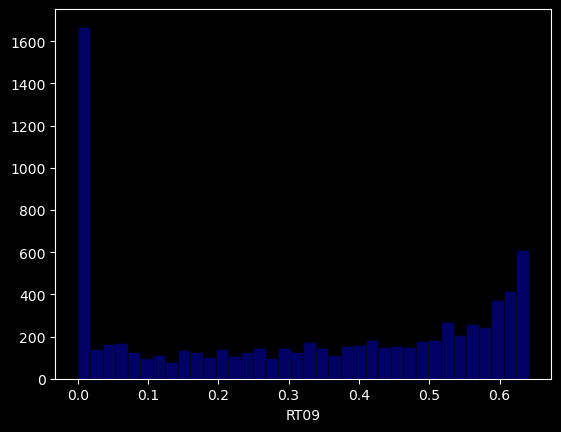

In [7]:
# Distribución de la tolerancia en 2009
sns.distplot(dataset2['RT09'], hist=True, kde=False,
             bins=int(180/5), color='blue',
             hist_kws={'edgecolor':'black'})

In [8]:
# Realizar una tercera copia del dataset
dataset3 = copy.deepcopy(dataset2)
# Filtrar por inversores inteligentes, aquellos
# que no modifican su riesgo más del 10%
dataset3 = dataset3[dataset3['PercentageChange'] <= 0.15]
# Calculo de la tolerancia media de estos inversores
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09']) / 2.0
# Eliminar columnas innecesarias para el estudio
dataset3 = dataset3.drop(labels=['RT07', 'RT09', 'PercentageChange'], axis=1)
# Ver los que han quedado
dataset3.shape[0]

501

<Axes: xlabel='TrueRiskTolerance'>

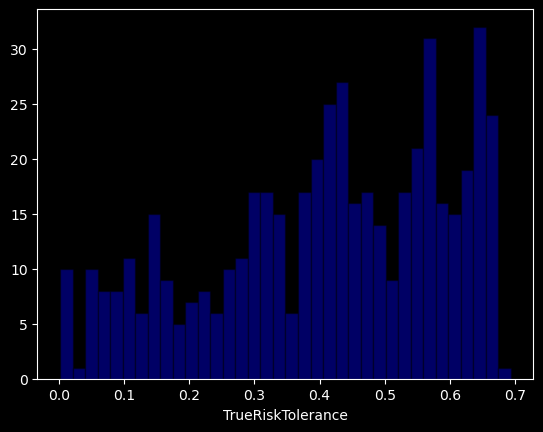

In [9]:
# Visualizar la distribución de la tolerancia al riesgo de los inversores inteligentes
sns.distplot(dataset3['TrueRiskTolerance'], hist=True, kde=False,
             bins=int(180/5), color='blue',
             hist_kws={'edgecolor':'black'})

In [25]:
# Selección de características para estimar la tolerancia al riesgo
dataset3 = dataset3[
    ['AGE07', 'EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance']
].reset_index(drop=True)
dataset3.to_csv('data/InputData.csv', index=True)

<Axes: title={'center': 'Matriz de correlaciones'}>

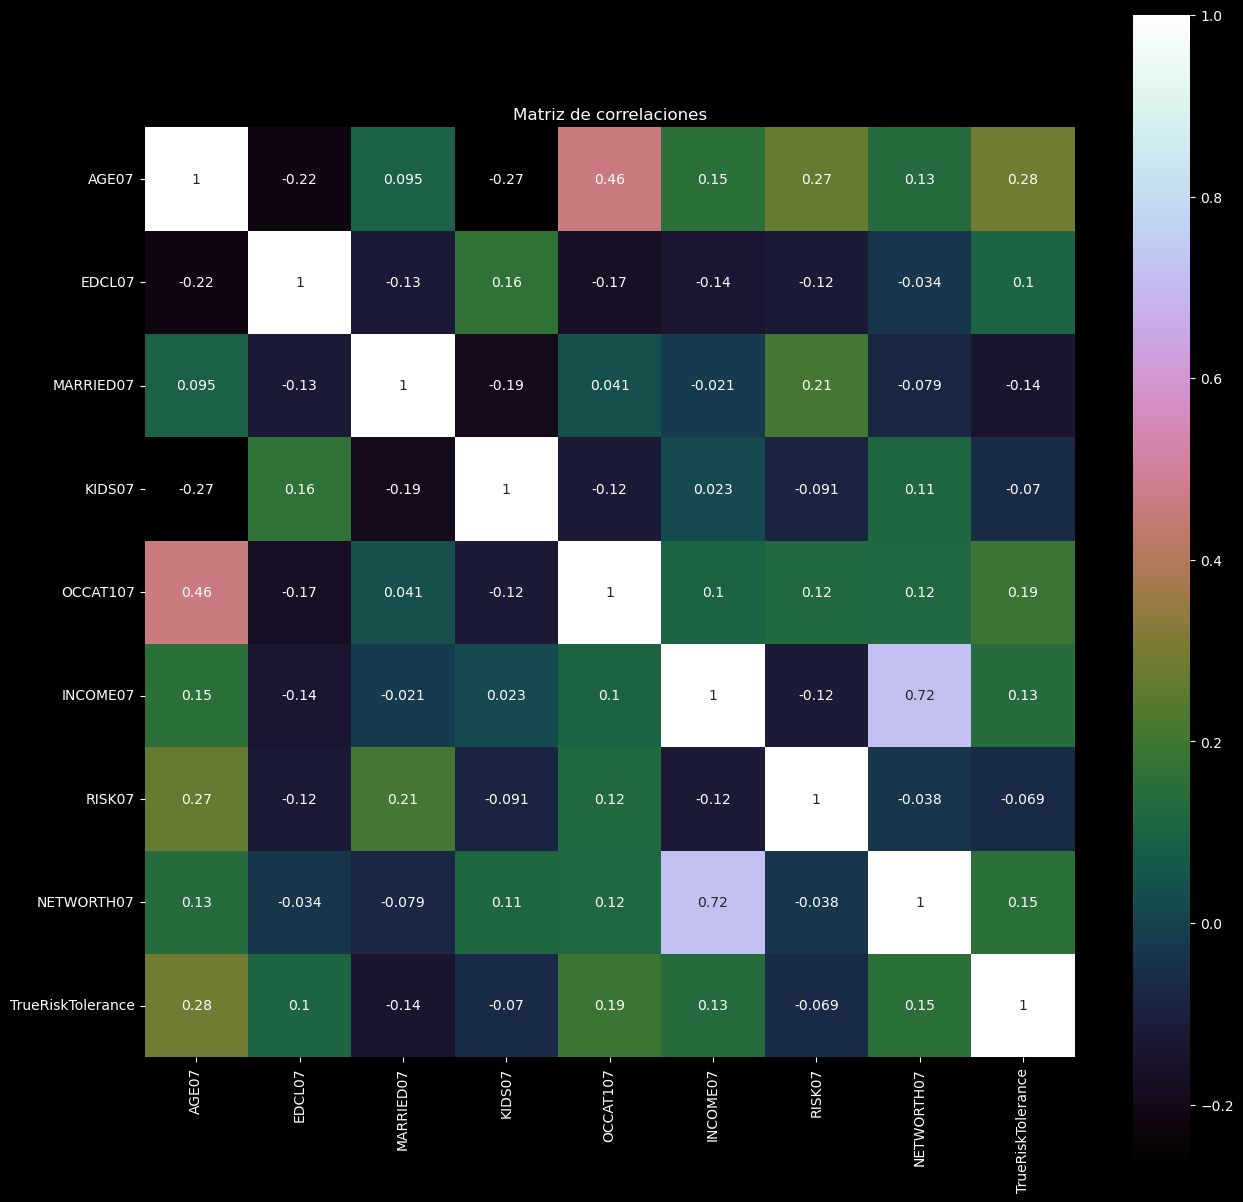

In [11]:
# Visualizar la correlación de características
correlation = dataset3.corr()
plt.figure(figsize=(15, 15))
plt.title("Matriz de correlaciones")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

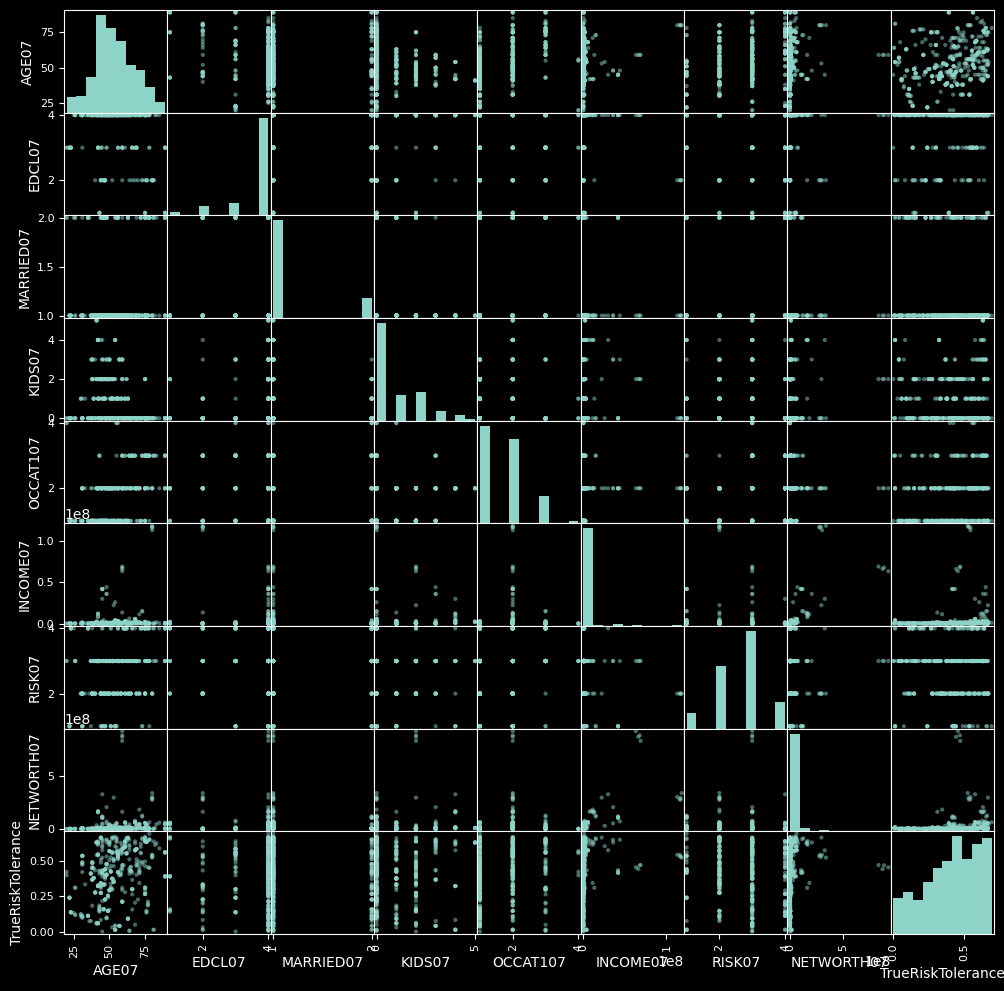

In [12]:
# Nube de puntos entre características
plt.figure(figsize=(15, 15))
scatter_matrix(dataset3, figsize=(12, 12))
plt.show()

In [13]:
# Características y objetivo
Y = dataset3['TrueRiskTolerance']
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)
validation_size = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

In [14]:
# número de iteraciones k-folds
num_folds = 10
#scoring = 'neg_mean_squared_error'
#scoring = 'neg_mean_absolute_error'
scoring = 'r2'

In [15]:
# modelos
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#models.append(('MLP', MLPRegressor()))
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [16]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    # convierto el mse a positivo, el menor es el mejor
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean():.6f} ({cv_results.std():.6f})"
    print(msg)

LR: -0.118082 (0.141721)
LASSO: -0.003624 (0.021665)
EN: -0.024588 (0.044881)
KNN: -0.397629 (0.132307)
CART: -0.493311 (0.365955)
SVR: -0.105240 (0.085146)
ABR: -0.364187 (0.112181)
GBR: -0.641803 (0.132417)
RFR: -0.725190 (0.159983)
ETR: -0.769454 (0.179561)


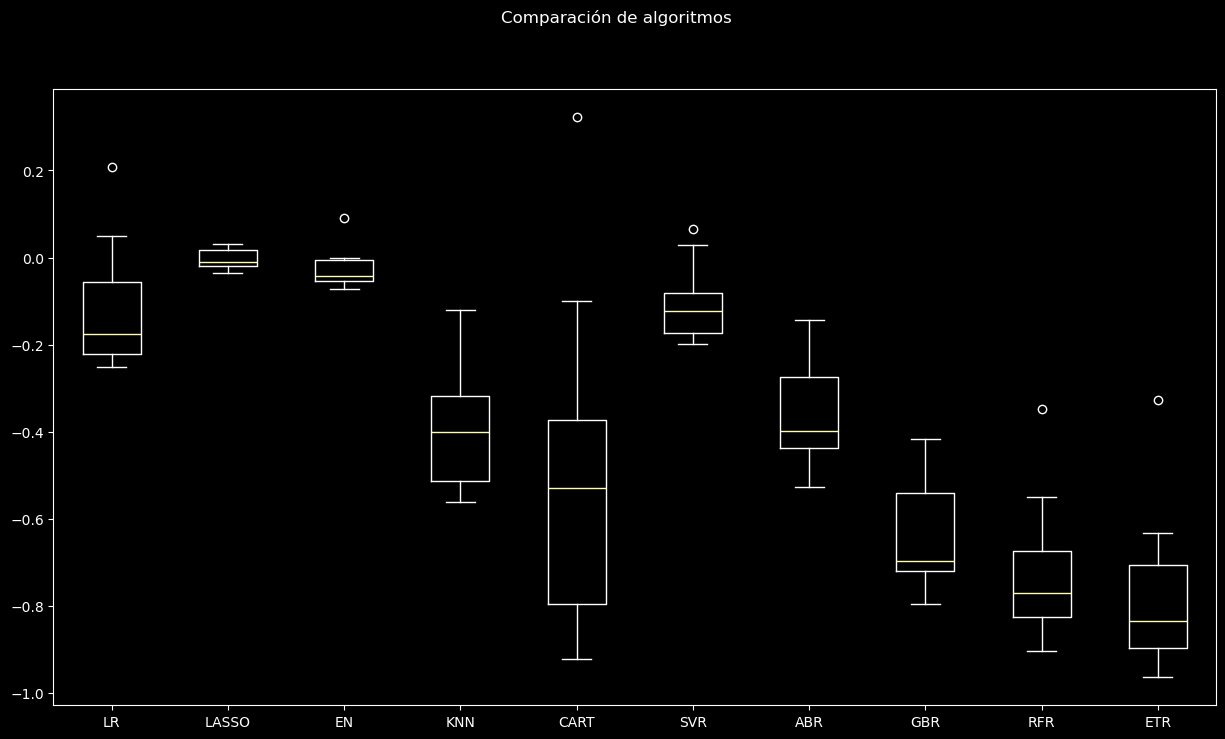

In [17]:
# visualización comparativa
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Comparación de algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.show()

In [18]:
# Tuneando el modelo con Grid Search
## n_estimators: integer, optional (default=10)
## El número de árboles del bosque
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)
grid_result = grid.fit(X_train, Y_train)
print(f"Mejor: {grid_result.best_score_} usando {grid_result.best_estimator_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.6f} ({stdev:.6f}) con: {param}")

Mejor: 0.6989728071485157 usando RandomForestRegressor(n_estimators=400)
0.678644 (0.134489) con: {'n_estimators': 50}
0.690057 (0.137002) con: {'n_estimators': 100}
0.697560 (0.125871) con: {'n_estimators': 150}
0.698949 (0.131784) con: {'n_estimators': 200}
0.691428 (0.135902) con: {'n_estimators': 250}
0.698049 (0.139249) con: {'n_estimators': 300}
0.694011 (0.143428) con: {'n_estimators': 350}
0.698973 (0.131329) con: {'n_estimators': 400}


In [19]:
# Preparando el modelo con el mejor hiperparámetro encontrado
model = RandomForestRegressor(n_estimators=grid_result.best_estimator_.get_params()['n_estimators'])
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=400)

In [20]:
predictions_train = model.predict(X_train)
print(f"{r2_score(Y_train, predictions_train):.6f}")

0.965624


In [21]:
# estimación de la precisión en validación
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(f"{r2_score(Y_validation, predictions):.6f}")
print(f"{mean_squared_error(Y_validation, predictions):.6f}")


0.820949
0.006970


[0.17470288 0.01993687 0.01120251 0.05692512 0.02627171 0.28379181
 0.05389591 0.37327319]


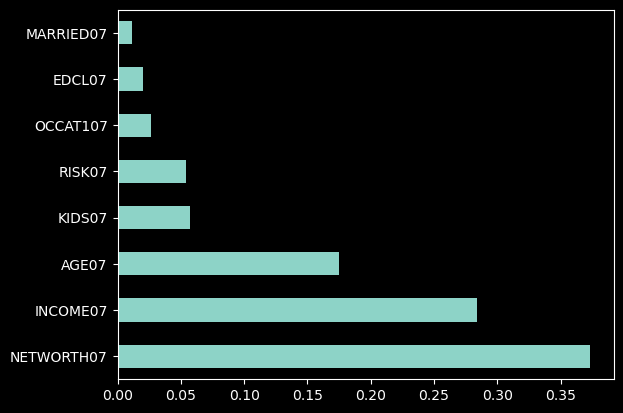

In [22]:
# Encontrar las características más relevantes
print(f"{model.feature_importances_}")
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [26]:
# Grabar el modelo para usarlo más adelante
filename = 'data/finalized_model.sav'
dump(model, open(filename, 'wb'))

: 

In [24]:
# Cargar el modelo desde archivo
loaded_model = load(open(filename, 'rb'))
# Comprobar los resultados de validación
predictions = loaded_model.predict(X_validation)
print(f"{r2_score(Y_validation, predictions):.6f}")
print(f"{mean_squared_error(Y_validation, predictions):.6f}")

0.820949
0.006970
